# Models

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

import matplotlib.pyplot as plt

## Linear Model

In [2]:
# Linear model
scaled_data = pd.read_csv('info_data.csv')
data_info = pd.read_csv('info_datav2.csv')
originaldata = pd.read_csv('../Data/Venta_Consumidor_Producto_UPC_PrevVTA_2018.csv')

In [3]:
traindataset, testdataset = train_test_split(data_info, test_size=0.3, random_state=42)
x_train = traindataset.loc[:, traindataset.columns != 'IMP_VENTA_NETO_EUR']
y_train = traindataset.loc[:, traindataset.columns == 'IMP_VENTA_NETO_EUR']
x_train = x_train.drop(columns=['EDAD_RANGO_COMPRA'])
x_test = testdataset.loc[:, traindataset.columns != 'IMP_VENTA_NETO_EUR']
y_test = testdataset.loc[:, traindataset.columns == 'IMP_VENTA_NETO_EUR']
x_test = x_test.drop(columns = 'EDAD_RANGO_COMPRA')

In [4]:
lm = LinearRegression()
model = lm.fit(x_train, y_train)
y_pred = lm.predict(x_test)
results = y_test.copy()
results['lm'] = y_pred

In [5]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 27.014766534168718
Mean Squared Error: 1268.233776101367
Root Mean Squared Error: 35.61227002174064


## XGBoost Model

In [6]:
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))
params = {'max_depth':3, 'eta':0.2, 'subsample':1}
num_rounds = 1500
bst = xgb.train(params, dtrain, num_rounds)
y_pred = bst.predict(dtest)
results['xgboost'] = y_pred

In [7]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 11.650974363512166
Mean Squared Error: 257.62767019055997
Root Mean Squared Error: 16.050784098932986


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

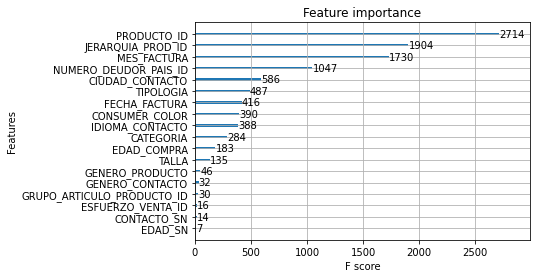

In [8]:
xgb.plot_importance(bst)

## k-nearest neighbour regression

In [17]:
rmse_val = [] #to store rmse values for different k
mse_val = []
model = neighbors.KNeighborsRegressor(n_neighbors = 7)
model.fit(x_train, y_train)  #fit the model
y_pred=model.predict(x_test) #make prediction on test set
mse = metrics.mean_squared_error(y_test, y_pred)
error = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) #calculate rmse
rmse_val.append(error) #store rmse values
mse_val.append(mse)
results['knn'] = y_pred

In [22]:
#curvermse = pd.DataFrame(rmse_val) #elbow curve 
#curvermse.plot()
#curvemse = pd.DataFrame(mse_val)
#curvemse.plot()

## Gaussian process regression

In [23]:
#params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

#knn = neighbors.KNeighborsRegressor()

#model = GridSearchCV(knn, params, cv=10)
#model.fit(x_train,y_train)
#model.best_params_

In [24]:
# massive dataset, try with something smaller
#kernel = DotProduct() + WhiteKernel()
#gpr = GaussianProcessRegressor(kernel=kernel).fit(x_train, y_train)
#gpr.score(x_train, y_train)
#y_pred = gpr.predict(x_test, return_std=True)
#results['gaussianP'] = y_pred